# Board Game Review Prediction



### Load relevant data, clean it, and begin exploring

In [1]:
#Import packages to be used
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
matplotlib.style.use('ggplot')
%matplotlib inline

#Load in the data and tell me something about it
import sqlite3
conn = sqlite3.connect("./DataSets/Board-game-database.sqlite")
query = "SELECT * FROM BoardGames"
df_boardgame_full = pd.read_sql_query(query,conn)

In [2]:
#Let's look at what fields we have available
df_boardgame_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90400 entries, 0 to 90399
Data columns (total 81 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   row_names                                 90400 non-null  object 
 1   game.id                                   90400 non-null  object 
 2   game.type                                 90400 non-null  object 
 3   details.description                       90400 non-null  object 
 4   details.image                             83508 non-null  object 
 5   details.maxplayers                        90397 non-null  float64
 6   details.maxplaytime                       90397 non-null  float64
 7   details.minage                            90397 non-null  float64
 8   details.minplayers                        90397 non-null  float64
 9   details.minplaytime                       90397 non-null  float64
 10  details.name                      

In [3]:
#Parse down fields to those which describe attributes of the game
df_boardgame = df_boardgame_full.loc[:,
                                     ('game.id',
                                      'game.type',
                                      'details.description',
                                      'details.maxplayers',
                                      'details.maxplaytime',
                                      'details.minage',
                                      'details.minplayers',
                                      'details.minplaytime',
                                      'details.name',
                                      'details.playingtime',
                                      'details.yearpublished',
                                      'attributes.boardgamecategory',
                                      'attributes.boardgamemechanic',
                                      'attributes.boardgamepublisher',
                                      'stats.averageweight',
                                      'stats.average')]

## Data Visualization on different factors
Exploratory Data Analysis - does this for Machine Learning enthusiast. It is a way of visualizing, summarizing and interpreting the information that is hidden in rows and column format.

C:\Users\USER\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


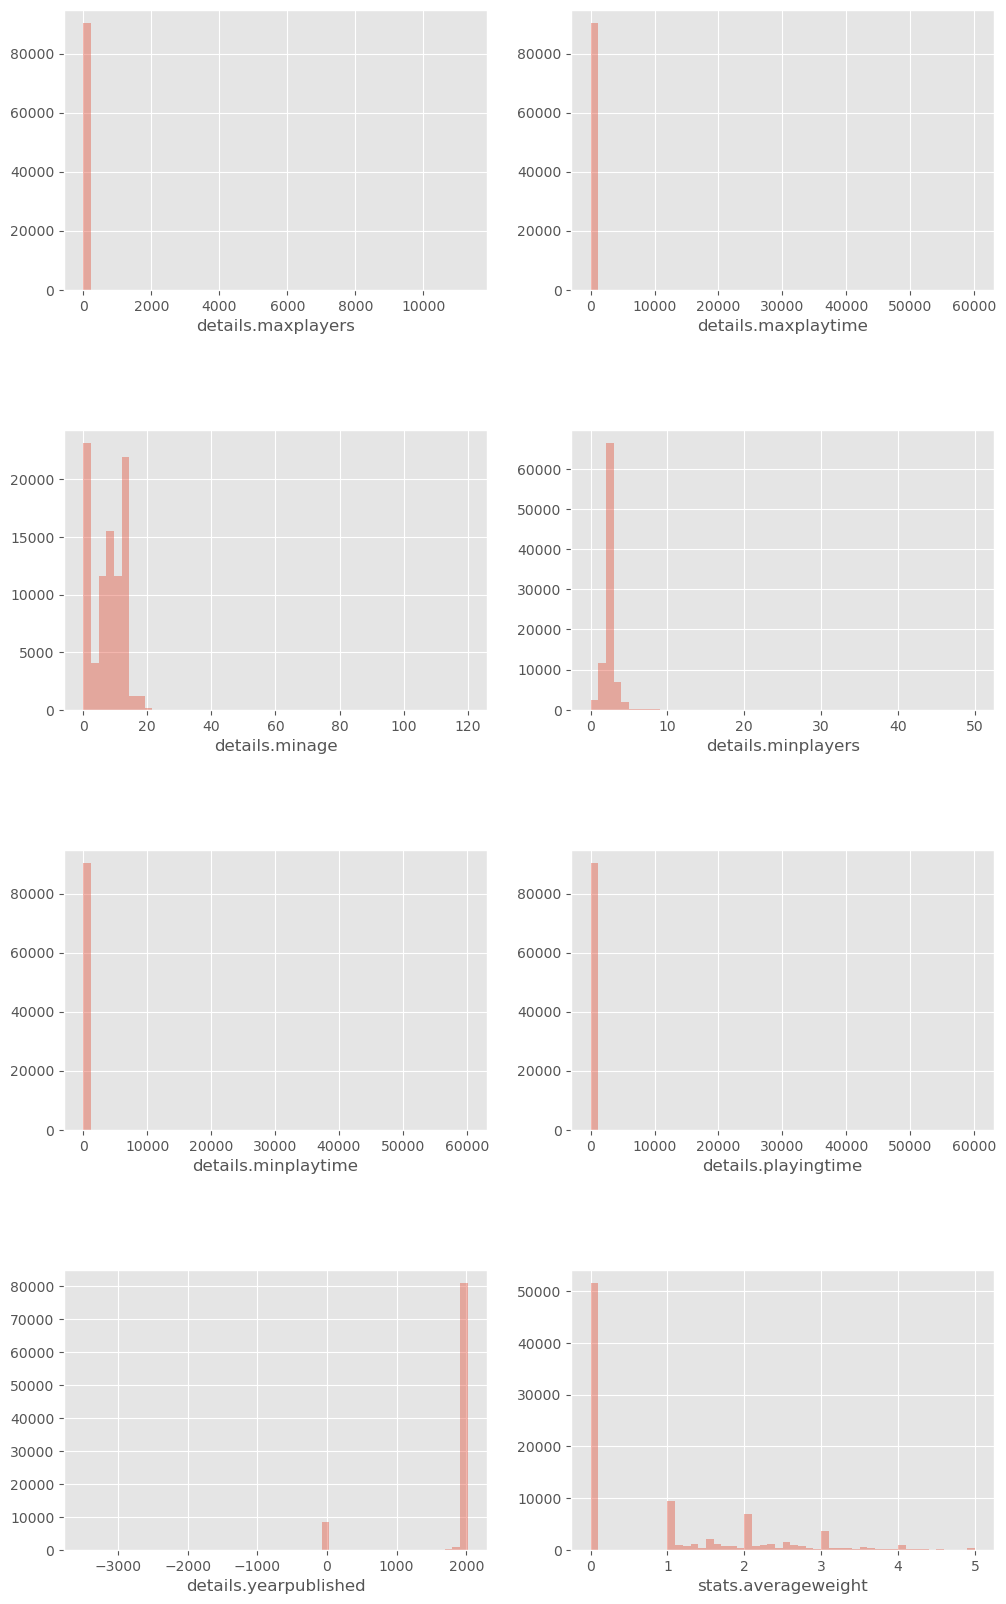

In [4]:
#Let's look at some distributions
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numdf = df_boardgame.select_dtypes(include=numerics)
numdf = numdf.dropna(axis=0, how='any')
numdf_variables = list(numdf)

#Set the number of graphs in the facet chart
graphs = len(numdf_variables)-1

#create a list of positions for the chart
position = []
for i in range(4):
    for j in range(2):
        b = i,j
        position.append(b)

#Create base of subplot chart.. rows x columbs = graphs
fig, axes = plt.subplots(nrows=4, ncols=2, sharey=False, sharex=False, figsize=(12,20))
fig.subplots_adjust(hspace=.5)

#Fill in base with graphs based off of position
for i in range(graphs):
    sns.distplot(numdf[numdf_variables[i]], ax=axes[position[i]], kde=False)

Okay, so we have some variable outliers/errors here that are making the distributions way out of whack. There are many ways to deal with these outliers/errors, which we'll take on a case by case basis.

### Calculate outliers for all numeric details


In [5]:
#Calculate outliers for all numeric details
for field in numdf_variables:
    value_mean = df_boardgame[field].median()
    value_q1 = df_boardgame[field].quantile(.25)
    value_q3 = df_boardgame[field].quantile(.75)
    value_qrange = value_q3-value_q1
    lower_outlier = value_q1-(4.5 * value_qrange)
    upper_outlier = value_q3+(4.5 * value_qrange)
    print(field)
    print(len(df_boardgame[df_boardgame[field]>upper_outlier]), 'upper outliers at', upper_outlier)
    print(len(df_boardgame[df_boardgame[field]<lower_outlier]), 'lower outliers at', lower_outlier)


details.maxplayers
1135 upper outliers at 24.0
0 lower outliers at -16.0
details.maxplaytime
1141 upper outliers at 307.5
0 lower outliers at -242.5
details.minage
4 upper outliers at 66.0
0 lower outliers at -54.0
details.minplayers
9803 upper outliers at 2.0
14126 lower outliers at 2.0
details.minplaytime
1158 upper outliers at 285.0
0 lower outliers at -215.0
details.playingtime
1141 upper outliers at 307.5
0 lower outliers at -242.5
details.yearpublished
0 upper outliers at 2129.0
8760 lower outliers at 1869.0
stats.averageweight
0 upper outliers at 9.625
0 lower outliers at -7.875
stats.average
0 upper outliers at 36.666685
0 lower outliers at -30.000014999999998


This may be complicated. Let's deal with these outliers later.

### Correlation Matrix

stats.average            1.000000
stats.averageweight      0.511930
details.minage           0.238825
details.yearpublished    0.192503
details.maxplaytime      0.050798
details.playingtime      0.050798
details.minplaytime      0.046227
details.minplayers       0.000049
details.maxplayers      -0.001663
Name: stats.average, dtype: float64

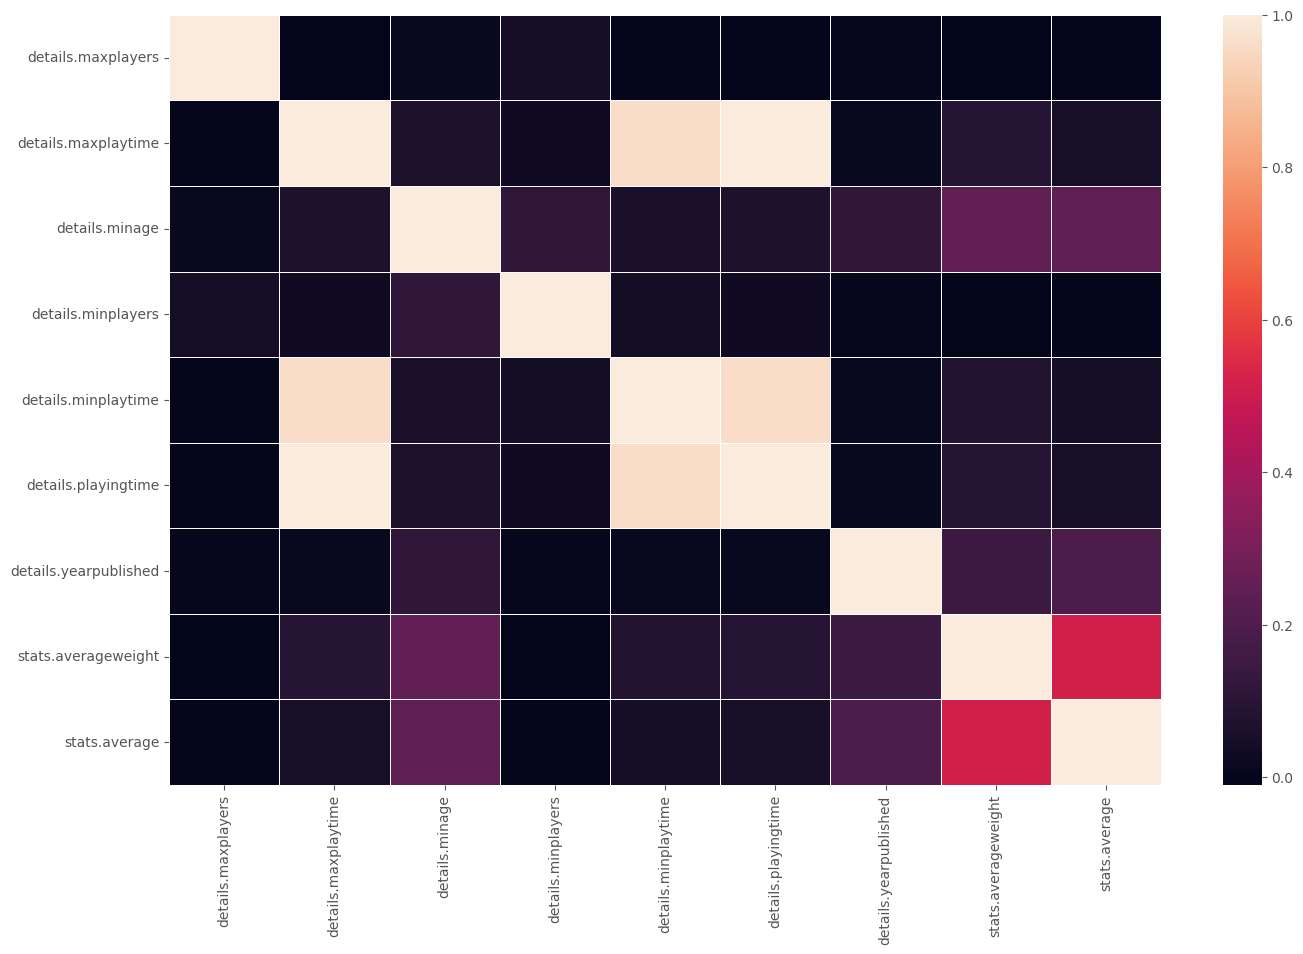

In [6]:
#Correlation Matrix
fig, ax = plt.subplots(figsize=(16,10))
corr = df_boardgame.corr()
corr = (corr)
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, linewidths=.5, ax=ax)
corr['stats.average'].sort_values(ascending=False)

The features most useful for us so far are:  stats.averageweight; details.yearpublished; details.minage

### Let's make a new dataframe to work on categorizing the boardgame correctly

In [7]:
#New manageable data frame
df_category = df_boardgame.loc[:, ['game.id','attributes.boardgamecategory']]
df_category['attributes.boardgamecategory'] = df_category['attributes.boardgamecategory'].fillna("None")

#Use comma splits to break out individual mechanical types
df_category = df_category['attributes.boardgamecategory'].apply(lambda x: pd.Series(x.split(',')))

#Sum the rows to determine most popular category types
category_counts = df_category.apply(pd.Series.value_counts).fillna(0)
category_counts['Total'] = category_counts.sum(axis=1)

#Let's get the most popular categories of games for our dataset
category_counts = category_counts.sort_values(by='Total', ascending=False)
category_list = category_counts[category_counts['Total']>500].index.tolist()

#Create dummies for all the boardgame categories
df_boardgame['attributes.boardgamecategory'].fillna(0, inplace=True)
for i in category_list:
    df_boardgame.loc[df_boardgame['attributes.boardgamecategory'].str.contains(i) == True ,i] = 1
    df_boardgame.loc[df_boardgame['attributes.boardgamecategory'].str.contains(i) == False ,i] = 0
    df_boardgame[i].fillna(0, inplace=True)

### Create a dataframe that takes boardgame categories and sorts by their overall mean rating

In [8]:
#Create a dataframe that takes boardgame categories and sorts by their overall mean rating
d =[]
for i in category_list:
    score = df_boardgame[df_boardgame[i]==1]['stats.average'].mean()
    d.append({'Avg_Rating': score, 'Game Type': i})
df_categorymean = pd.DataFrame(d).sort_values(by='Avg_Rating', ascending=False)
df_categorymean[:10]

,Avg_Rating,Game Type
69,6.447312,Renaissance
3,6.281217,Expansion for Base-game
58,6.035445,Civilization
19,5.789767,World War II
63,5.743018,World War I
27,5.722487,Medieval
7,5.711969,Miniatures
46,5.710972,City Building
51,5.677852,Napoleonic
47,5.604465,Trains


### Top rated and Lowest rated games categories

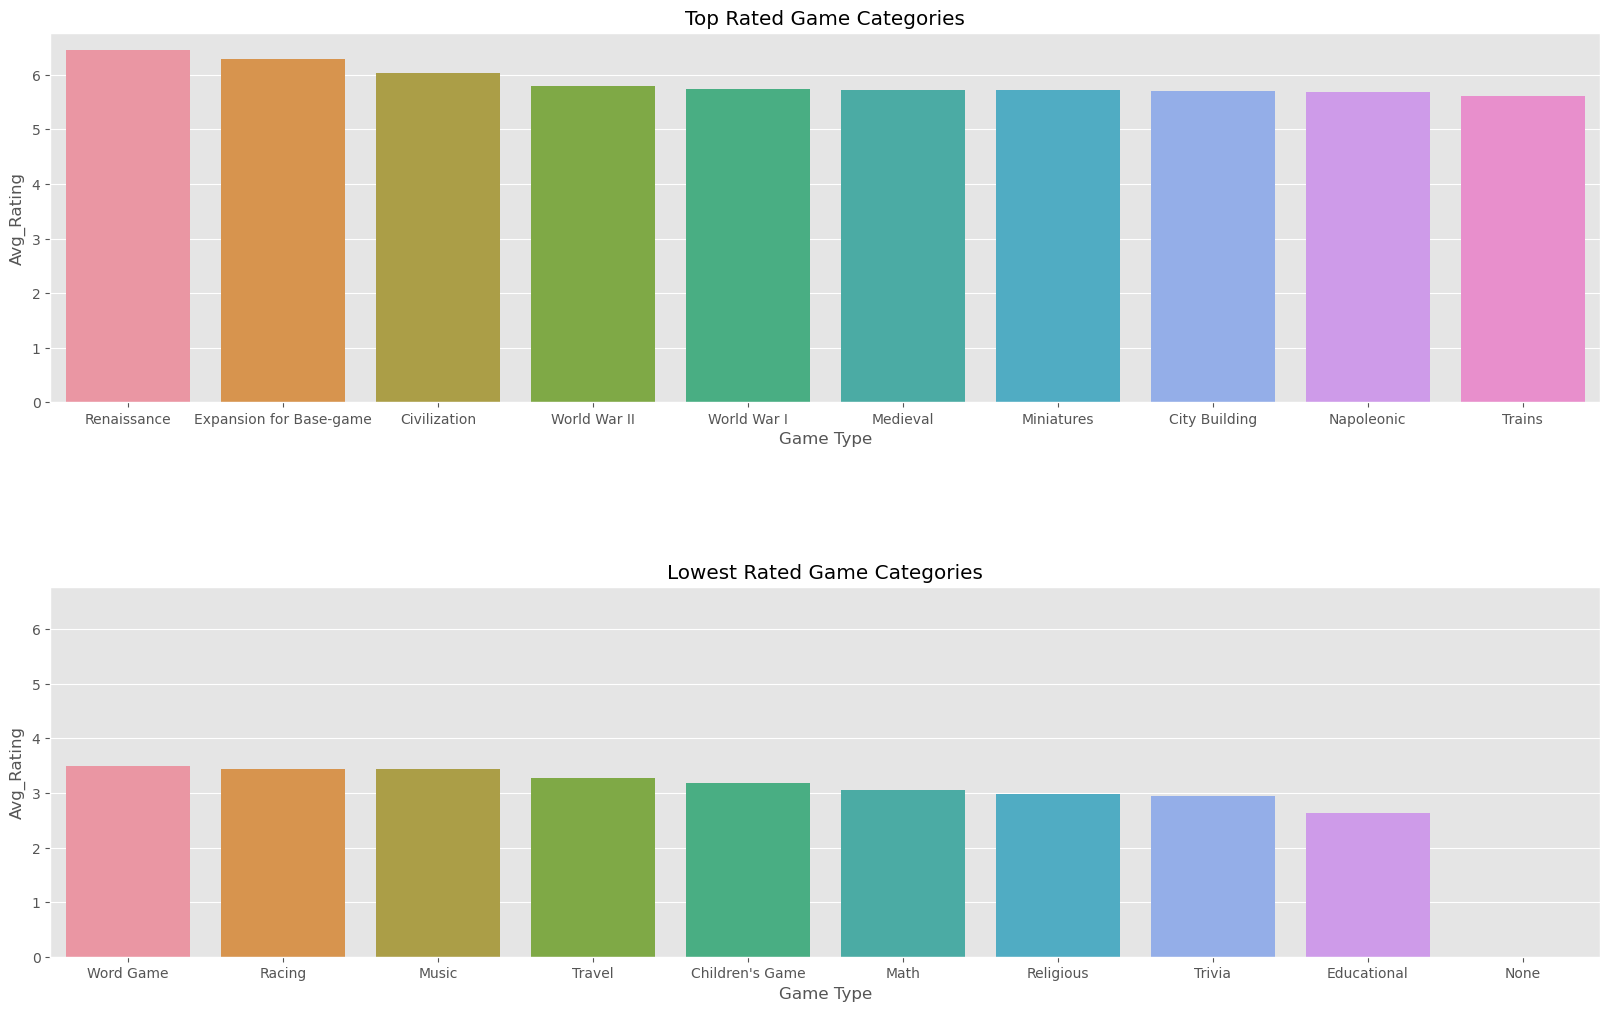

In [9]:
#Create base of subplot chart.. rows x columbs = graphs
fig, (ax1, ax2) = plt.subplots(nrows=2, sharey=True, sharex=False, figsize=(20,12))
fig.subplots_adjust(hspace=.5)
sns.barplot(x="Game Type", y="Avg_Rating", data=df_categorymean[:10], ax=ax1)
sns.barplot(x="Game Type", y="Avg_Rating", data=df_categorymean[-10:], ax=ax2)
ax1.title.set_text('Top Rated Game Categories')
ax2.title.set_text('Lowest Rated Game Categories')

**Takeaways:**  
1) Let's make an period-piece expansion boardgame set in conflict involving trains  
2) Let's not try to incorporate school subjects into our boardgames

In [10]:
#Drop outliers for details.minage
df_boardgame = df_boardgame[df_boardgame['details.minage']<66]

#Drop "The Ancients" i.e. games that came out before 1900
df_boardgame = df_boardgame[df_boardgame['details.yearpublished']>1900]

'''
I don't like these details.maxplayers and details.maxplaytime, because 0s indicate the opposite
of their direction impact i.e. maxplayers = 0 indicates infinite players
'''

"\nI don't like these details.maxplayers and details.maxplaytime, because 0s indicate the opposite\nof their direction impact i.e. maxplayers = 0 indicates infinite players\n"

In [11]:
model_data = df_boardgame.loc[:,
                                     (
                                      'game.type',
                                      'details.minage',
                                      'details.minplayers',
                                      'details.yearpublished',
                                      'attributes.boardgamecategory',
                                      'stats.averageweight',
                                      'stats.average')]

In [12]:
#Create dummies for all the boardgame categories on model_data
for i in category_list:
    model_data.loc[model_data['attributes.boardgamecategory'].str.contains(i) == True ,i] = 1
    model_data.loc[model_data['attributes.boardgamecategory'].str.contains(i) == False ,i] = 0
    model_data[i].fillna(0, inplace=True)

In [13]:
#Get dummy variables for boardgame/expansion type
model_data = pd.get_dummies(model_data, columns=['game.type'])

In [14]:
#Get rid of remaining object categories
model_data = model_data.loc[:, model_data.columns != 'attributes.boardgamecategory']

**Training and Testing Dataset Spliting using the `train_test_split`**

In [15]:
#Create Training / Test splits
from sklearn.model_selection import train_test_split

target_name = 'stats.average'
X = model_data.drop('stats.average', axis=1)
y=model_data[target_name]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, random_state=243)

### OLS Regression

In [16]:
#Let's use the basic OLS regression from sklearn
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X_train, y_train)

#What are the features that have the most weight?
ols_coefficients = pd.DataFrame({'feature': X_train.columns, 'importance': lm.coef_})
ols_coefficients.sort_values('importance', ascending=False)[:10]

,feature,importance
76,game.type_boardgameexpansion,2.651326e+10
75,game.type_boardgame,2.651326e+10
3,stats.averageweight,1.035135e+00
73,Renaissance,9.586198e-01
51,Trains,5.112398e-01
31,Medieval,4.238409e-01
45,Aviation / Flight,4.104856e-01
29,Bluffing,3.726123e-01
55,Napoleonic,3.685722e-01
41,Real-time,3.205514e-01


In [17]:
#Get OLS mean squared error on test dataset 
from sklearn import metrics
ols_y_predict = lm.predict(X_test)
ols_mse = np.sqrt(metrics.mean_squared_error(y_test, ols_y_predict))
ols_mse

2.341766816718152

In [18]:
print(f'R2-Score: {metrics.r2_score(y_test, ols_y_predict)}')

R2-Score: 0.34720929520363353


### Random Forest Regression 

<AxesSubplot:xlabel='feature'>

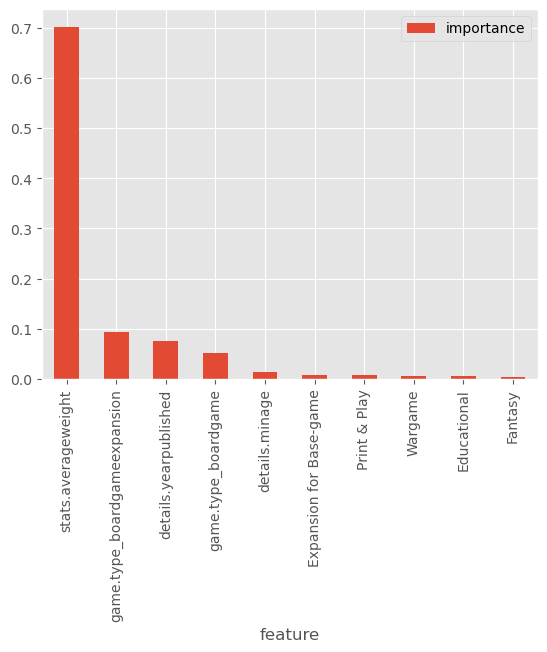

In [19]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(max_depth=7, random_state=0)
rf.fit(X_train, y_train)
rf_importances = rf.feature_importances_
feat_names = X_train.columns
rf_result = pd.DataFrame({'feature': feat_names, 'importance': rf_importances})
rf_result.sort_values(by='importance',ascending=False)[:10].plot(x='feature', y='importance', kind='bar')

In [20]:
#Get Random Forest mean squared error on test dataset
rf_y_predict = rf.predict(X_test)
rf_mse = np.sqrt(metrics.mean_squared_error(y_test, rf_y_predict))
rf_mse

2.2270008236744814

In [21]:
print(f'R2-Score: {metrics.r2_score(y_test, rf_y_predict)}')

R2-Score: 0.40962572973950906


### Decision Tree Regressor

In [22]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)

DecisionTreeRegressor()

In [23]:
dtr_y_predict = dtr.predict(X_test)
dtr_mse = np.sqrt(metrics.mean_squared_error(y_test, dtr_y_predict))
dtr_mse

2.8193946032554353

In [24]:
print(f'R2-Score: {metrics.r2_score(y_test, dtr_y_predict)}')

R2-Score: 0.0537663363460561


### Lasso Regression

In [25]:
from sklearn import linear_model
lasso = linear_model.Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

Lasso(alpha=0.1)

In [26]:
lasso_y_predict = lasso.predict(X_test)
lasso_mse = np.sqrt(metrics.mean_squared_error(y_test, lasso_y_predict))
lasso_mse

2.389949076413906

In [27]:
print(f'R2-Score: {metrics.r2_score(y_test, lasso_y_predict)}')

R2-Score: 0.32007037957356943


### Ridge Regression


In [28]:
from sklearn import linear_model
ridge = linear_model.Ridge(alpha=0.1)
ridge.fit(X_train, y_train)

Ridge(alpha=0.1)

In [29]:
ridge_y_predict = ridge.predict(X_test)
ridge_mse = np.sqrt(metrics.mean_squared_error(y_test, ridge_y_predict))
ridge_mse

2.341766677872335

In [30]:
print(f'R2-Score: {metrics.r2_score(y_test, ridge_y_predict)}')

R2-Score: 0.34720937261292584


### XgBoost Regressor 

In [31]:
from xgboost.sklearn import XGBRegressor
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [32]:
xgb_y_predict = xgb.predict(X_test)
xgb_mse = np.sqrt(metrics.mean_squared_error(y_test, xgb_y_predict))
xgb_mse

2.1886239970049695

In [33]:
print(f'R2-Score: {metrics.r2_score(y_test, xgb_y_predict)}')

R2-Score: 0.4297976802022654


### Gradient Boosting Regressor 

In [34]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)

GradientBoostingRegressor()

In [35]:
gb_y_predict = gb.predict(X_test)
gb_mse = np.sqrt(metrics.mean_squared_error(y_test, gb_y_predict))
gb_mse

2.229192160009136

In [36]:
print(f'R2-Score: {metrics.r2_score(y_test, gb_y_predict)}')

R2-Score: 0.40846331877773456


### MLP Regressor 

In [37]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor()
mlp.fit(X_train, y_train)

MLPRegressor()

In [38]:
mlp_y_predict = mlp.predict(X_test)
mlp_mse = np.sqrt(metrics.mean_squared_error(y_test, mlp_y_predict))
mlp_mse

2.862702368232373

In [39]:
print(f'R2-Score: {metrics.r2_score(y_test, mlp_y_predict)}')

R2-Score: 0.024473523362236294


***************************
### Comparative analysis among the algorithms for this project



|Name of the Model|R2 Score|Mean Squared Error|
|:---:|:---:|:---:|
|OLS Regression|0.35|2.34|
|Decision Tree Regressor|0.05|2.83|
|Random Forest Regressor|0.41|2.23|
|Lasso Regression|0.32|2.39|
|Ridge Regression|0.35|2.34|
|XgBoost Regressor|0.41|2.23|
|MLP Regressor|0.02|2.86|
|Gradient Boosting Regressor|0.41|2.23|


### Conclusion

Best Fitted Models ranking - 
1. Gradient Boosting
2. XgBoosting Regressor
3. Random Forest
4. OLS Regression
5. Ridge Regressor
6. Lasso Regressor
7. Decision Tree Regressor
8. MLP Regressor


